In [45]:
import pandas as pd
import numpy as np
import os
import sys
import glob
import seaborn as sns
import imageio
import skimage
import matplotlib.colors as mcolors
import matplotlib.animation as animation
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.segmentation import join_segmentations
from skimage.color import rgb2gray
from tifffile import imread

<tifffile.TiffFrame 388 @157874034> is missing required tags
<tifffile.TiffFile 'cellsonlyA1.ome.tiff'> OME series expected 388 frames, got 389


(4, 97, 478, 666, 3)
(4, 97, 478, 666)


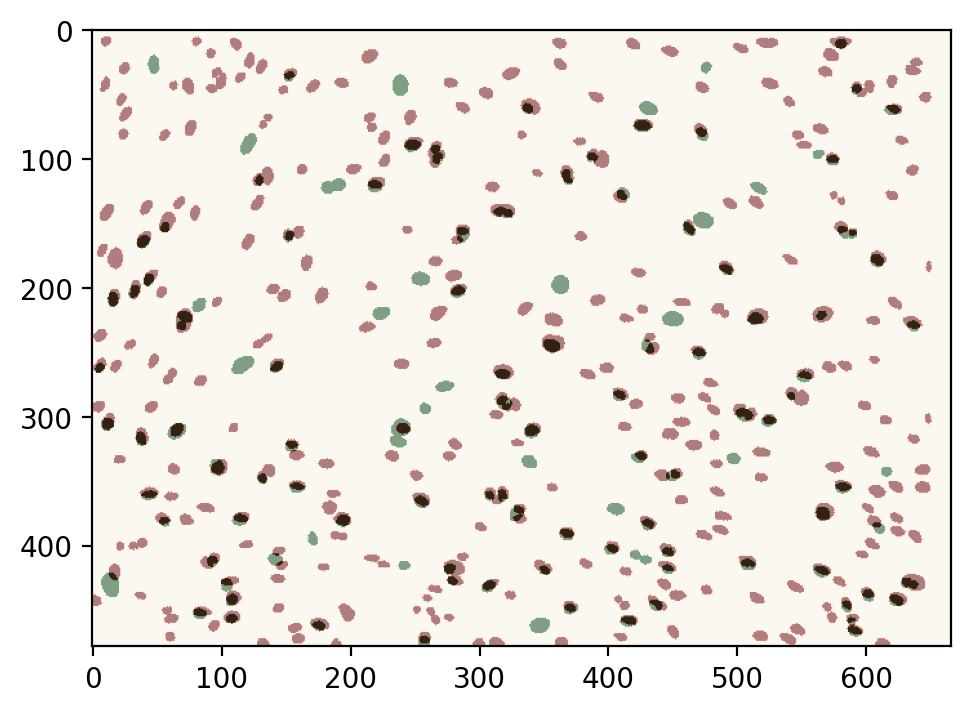

In [42]:
cell_id = 'cellsonlyA1'

fpath = f"/scratch/indikar_root/indikar1/shared_data/apollo/images/{cell_id}.ome.tiff"
raw_img = imread(fpath)
print(raw_img.shape)

fpath = f"/scratch/indikar_root/indikar1/shared_data/apollo/segmentation/{cell_id}.tiff"
img = imread(fpath)
print(img.shape)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 4

plt.imshow((img[2, 0, :, :] != 0 ), cmap='Reds', alpha=1.0)
plt.imshow((img[3, 0, :, :] != 0), cmap='Greens', alpha=0.5)


In [59]:
result = []

for t in range(img.shape[1]):
    
    # get each channel
    red_image = img[2, t, :, :]
    green_image = img[3, t, :, :]
    
    # count the number of unique segmentations in both channels
    n_red = len(np.unique(red_image)) - 1
    n_green = len(np.unique(green_image)) - 1
    
    # compute the overlap between segmentations
    # fraction of red_image that overlaps with green_image
    red_overlap = skimage.measure.intersection_coeff(
        red_image.astype(bool), 
        green_image.astype(bool)
    )
    
    # fraction of green_image that overlaps with red_image
    green_overlap = skimage.measure.intersection_coeff(
        green_image.astype(bool), 
        red_image.astype(bool),
    )
    
    # compute mander's colocalization for both channels
    # 'what' proportion of red intensity is in green segmentations?
    red_colocalization = skimage.measure.manders_coloc_coeff(
        rgb2gray(raw_img[2, t, :, :]), 
        green_image.astype(bool),
    )
    
    # 'what' proportion of green intensity is in red segmentations?
    green_colocalization = skimage.measure.manders_coloc_coeff(
        rgb2gray(raw_img[3, t, :, :]), 
        red_image.astype(bool),
    )
    
    row = {
        'time' : t,
        'n_red_cells' : n_red,
        'n_green_cells' : n_green,
        'red_overlap' : red_overlap,
        'green_overlap' : green_overlap,
        'red_colocalization' : red_colocalization,
        'green_colocalization' : green_colocalization,
    }
    
    result.append(row)
    
result = pd.DataFrame(result)
# Calculate the 'both' count from red overlap
both_from_red = result['n_red_cells'] * (result['red_overlap'])

# Calculate the 'both' count from green overlap
both_from_green = result['n_green_cells'] * (result['green_overlap'])

# Ideally, these should be close. Let's take the average for a more robust estimate
both_avg = (both_from_red + both_from_green) / 2

# Calculate exclusively red and green counts
only_red = result['n_red_cells'] - both_avg
only_green = result['n_green_cells'] - both_avg

# Add these calculated columns to your DataFrame
result['n_both'] = both_avg.astype(int)
result['n_only_red'] = only_red.astype(int)
result['n_only_green'] = only_green.astype(int)

result.head()

,time,n_red_cells,n_green_cells,red_overlap,green_overlap,red_colocalization,green_colocalization,n_both,n_only_red,n_only_green
0,0,339,129,0.230115,0.545985,0.278987,0.105337,74,264,54
1,1,341,123,0.226756,0.567678,0.237117,0.108846,73,267,49
2,2,364,116,0.202447,0.565743,0.203223,0.112850,69,294,46
3,3,360,109,0.192354,0.583072,0.178988,0.112585,66,293,42
4,4,359,116,0.209867,0.621495,0.175308,0.113124,73,285,42


<Axes: xlabel='time', ylabel='value'>

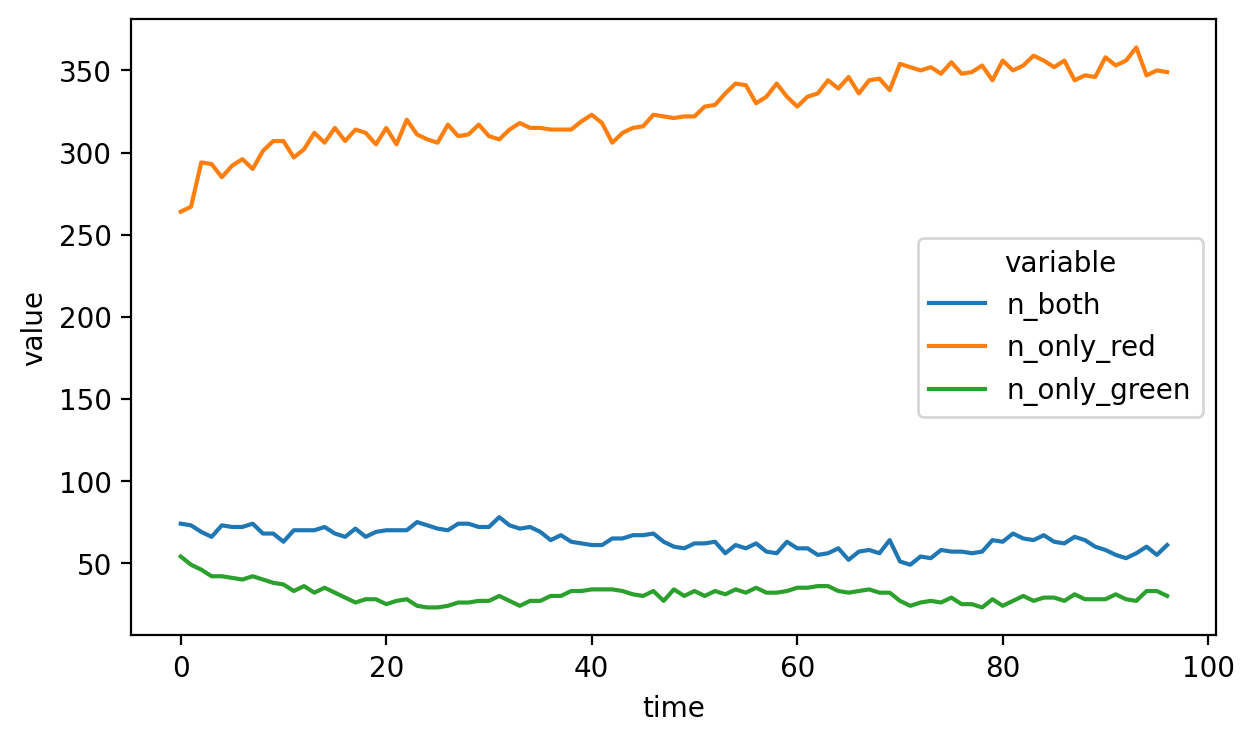

In [60]:
sns.lineplot(
    pd.melt(result, id_vars='time', value_vars=['n_both', 'n_only_red', 'n_only_green']),
    x='time',
    y='value',
    hue='variable',
)